<a href="https://colab.research.google.com/github/ravishankarramakrishnan/Deep_Learning_Practice/blob/master/Transfer_Learning_for_Food_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting the Collab Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Importing the Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import PIL
from IPython.display import display

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/training'):
    print('Training:', i)

for i in os.listdir('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/validation'):
    print('Validation:', i)

Training: Bread
Training: Dairy product
Training: Dessert
Training: Egg
Training: Fried food
Training: Meat
Training: Noodles-Pasta
Training: Rice
Training: Seafood
Training: Soup
Training: Vegetable-Fruit
Validation: Bread
Validation: Dairy product
Validation: Dessert
Validation: Egg
Validation: Fried food
Validation: Meat
Validation: Noodles-Pasta
Validation: Rice
Validation: Seafood
Validation: Soup
Validation: Vegetable-Fruit


In [4]:
# Get the Number of Images in Training, Validation and Testing

train, valid, test = [], [], []

# Loop for looping all images

for i in os.listdir('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/training'): # Just for Folder
    train.extend(os.listdir(os.path.join('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/training', i)))
    valid.extend(os.listdir(os.path.join('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/validation', i)))
    test.extend(os.listdir(os.path.join('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/evaluation', i)))

# Validate
print("The Number of Training Images are {a} \nThe Number of Validation Images are {b} \nThe Number of Test Images are {c}".format(
    a = len(train),
    b = len(valid),
    c = len(test)
))

The Number of Training Images are 9867 
The Number of Validation Images are 3430 
The Number of Test Images are 3347


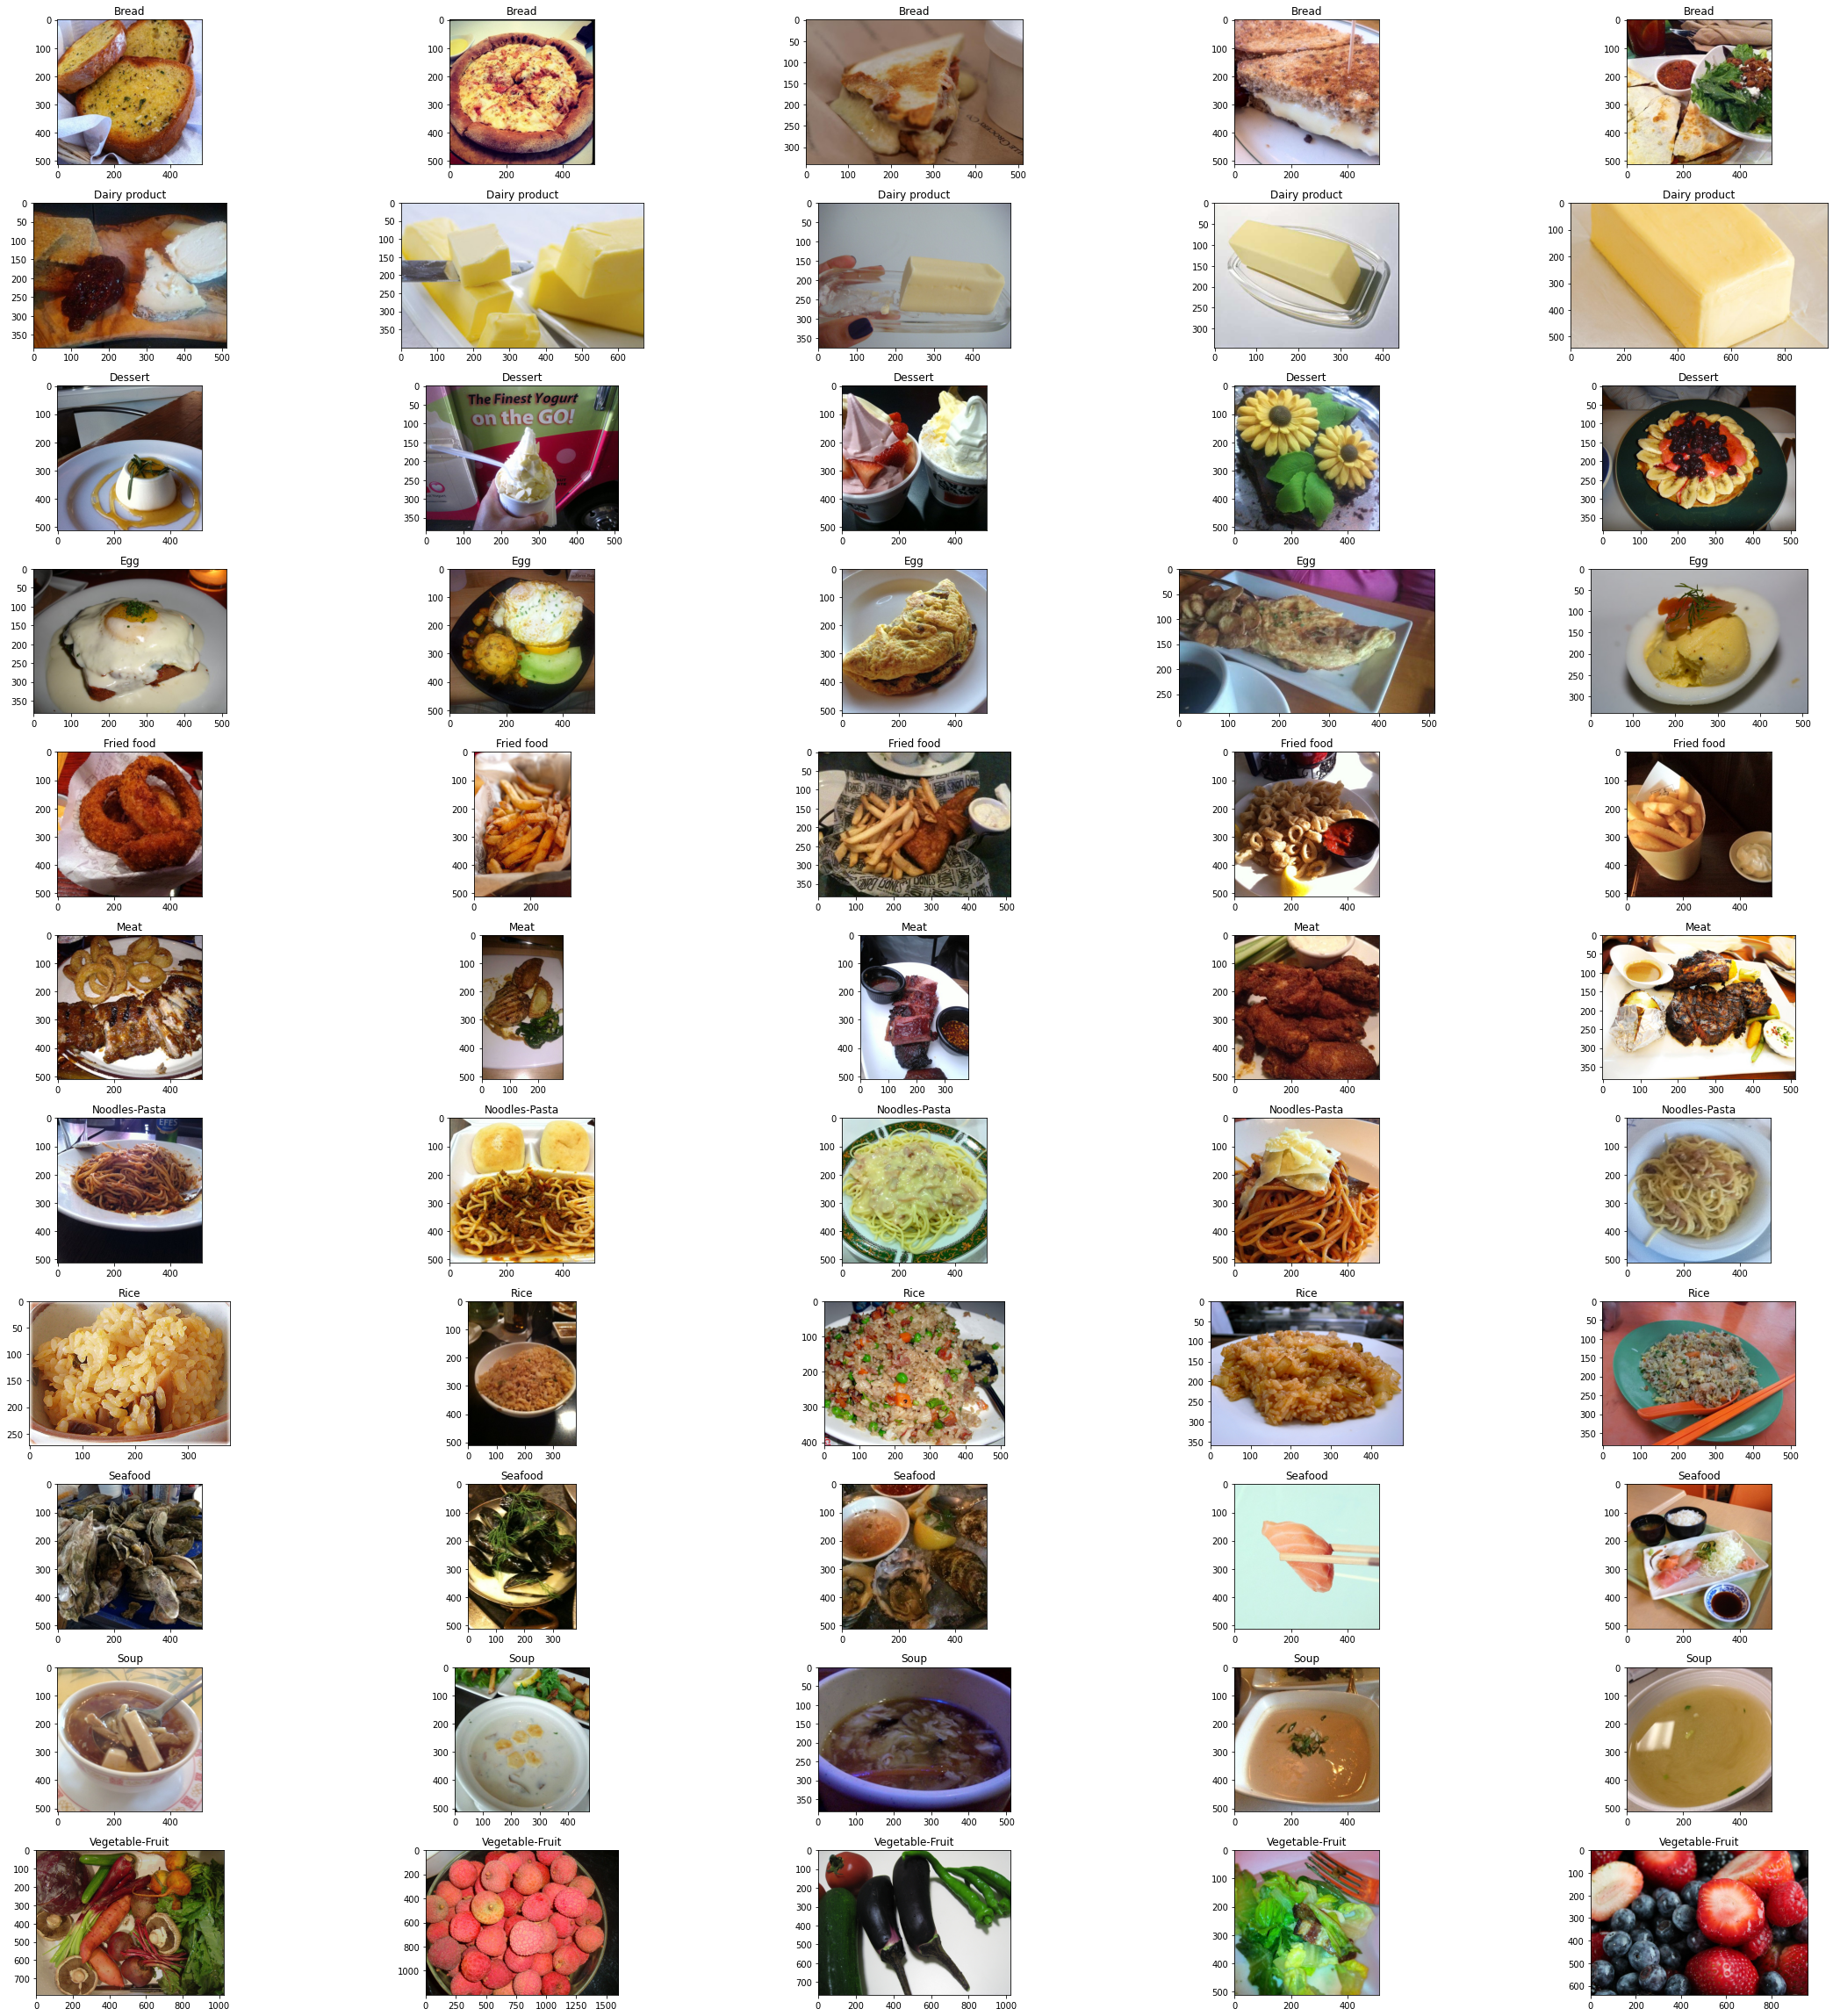

In [5]:
# Performing Data Exploration

# Visualize a Grid of Images

fig, ax = plt.subplots(nrows= 11, ncols= 5, figsize= (32, 32))
count = 0
# Loop for Every class in the Dataset
for i in os.listdir('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/training'):
    train_class = os.listdir(os.path.join('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/training', i))
    
    # Plot 5 Images in the class
    for j in range(5):
        img = os.path.join('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/training', i, train_class[j])
        ax[count][j].title.set_text(i)
        ax[count][j].imshow(PIL.Image.open(img))
    count += 1

fig.tight_layout();

In [6]:
# Check the Number of Images in each class of the Training Data

no_images_per_class = []
class_name = []
for i in os.listdir('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/training'):
    class_name.append(i)
    train_class = os.listdir(os.path.join('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/training', i))
    print(f"The Number of Images in {i} is {len(train_class)}")
    no_images_per_class.append(len(train_class))

The Number of Images in Bread is 994
The Number of Images in Dairy product is 429
The Number of Images in Dessert is 1500
The Number of Images in Egg is 986
The Number of Images in Fried food is 849
The Number of Images in Meat is 1325
The Number of Images in Noodles-Pasta is 440
The Number of Images in Rice is 280
The Number of Images in Seafood is 855
The Number of Images in Soup is 1500
The Number of Images in Vegetable-Fruit is 709


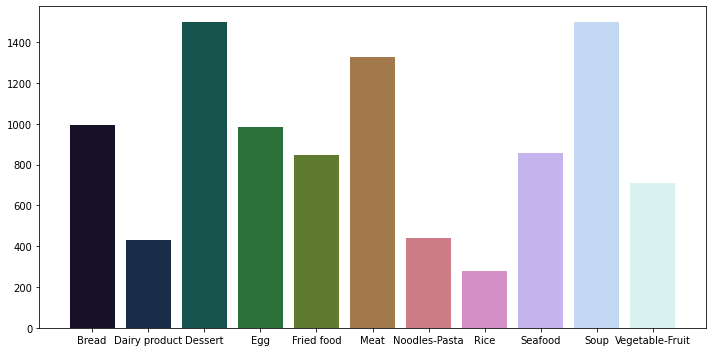

In [7]:
# We can see we have a little bit of Class Imbalance

# Visualize the Class via bar Chart
fig = plt.figure(figsize= (10, 5))
plt.bar(class_name, no_images_per_class, color= sns.color_palette('cubehelix', len(class_name)))
fig.tight_layout();

The Number of Images in Bread is 362
The Number of Images in Dairy product is 144
The Number of Images in Dessert is 500
The Number of Images in Egg is 327
The Number of Images in Fried food is 326
The Number of Images in Meat is 449
The Number of Images in Noodles-Pasta is 147
The Number of Images in Rice is 96
The Number of Images in Seafood is 347
The Number of Images in Soup is 500
The Number of Images in Vegetable-Fruit is 232


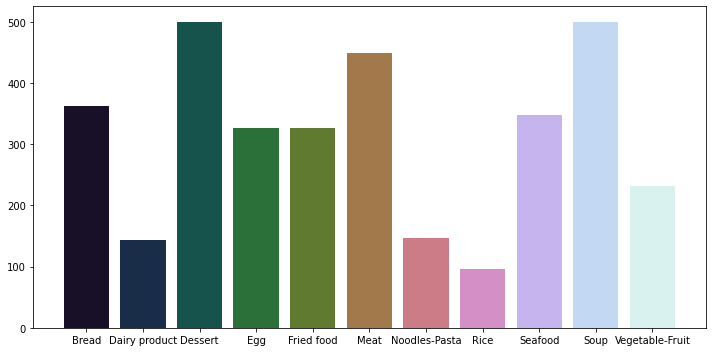

In [8]:
# Create for Validation Dataset

# Check the Number of Images in each class of the Training Data

val_no_images_per_class = []
val_class_name = []
for i in os.listdir('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/validation'):
    val_class_name.append(i)
    train_class = os.listdir(os.path.join('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/validation', i))
    print(f"The Number of Images in {i} is {len(train_class)}")
    val_no_images_per_class.append(len(train_class))

# Visualize the Distribution via bar Chart
fig = plt.figure(figsize= (10, 5))
plt.bar(val_class_name, val_no_images_per_class, color= sns.color_palette('cubehelix', len(val_class_name)))
fig.tight_layout();

In [9]:
# Perform Image Augmentation and create Data Generator - RunTime Augmentation on Training and Validation sets
# Generate Images in Batches - https://keras.io/api/preprocessing/image/

# Train Datagen
train_datagen = ImageDataGenerator(rescale= 1./255.,  # Normalisation
                                   zoom_range= 0.2,
                                   shear_range= 0.2,
                                   horizontal_flip= True)

test_datagen = ImageDataGenerator(rescale= 1./255.) # Only Normalisation, No Image Augmentation

# Create Data Generator for Training, Validation and Test Data

train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/training',
                                                    target_size= (256, 256),
                                                    batch_size= 32,
                                                    class_mode= 'categorical')

validation_generator = test_datagen.flow_from_directory('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/validation',
                                                        target_size= (256, 256),
                                                        batch_size= 32,
                                                        class_mode= 'categorical')

test_generator = test_datagen.flow_from_directory('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/evaluation',
                                                   target_size= (256, 256),
                                                   batch_size= 32,
                                                   class_mode= 'categorical')

# A Train Generator has batches of Images along with their corresponding Labels

Found 9867 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


In [ ]:
# Build Model using Pre Trained Inception Resnet V2

# Load InceptionResnet V2 Model | You can also use ResNet50 or MobileNet

basemodel = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor= Input(shape= (256,256,3))) # include_top is head model. It is where you add your model.
basemodel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 127, 127, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 127, 127, 32) 0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [ ]:
# Freeze BaseModel Weights, so the weights wont change during Training

basemodel.trainable = False # Freezes all weights of the Base Model

In [ ]:
# Add Classification Head to the Model -> Transfer Learning [Loaded a Pretrained Network and Added Layers/Tune it]

headmodel = basemodel.output
# Add Global Averagepooling 2D, Flatten and then pass to the Model

headmodel = GlobalAveragePooling2D(name= 'global_average_pool')(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(units= 512, activation= 'relu', name= 'dense_1')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(units= 256, activation= 'relu', name= 'dense_2')(headmodel)
headmodel = Dropout(0.25)(headmodel)
#headmodel = Dense(units= 128, activation= 'relu', name= 'dense_3')(headmodel)
#headmodel = Dropout(0.3)(headmodel)

# Last Layer (Output)  - > The Above is commented so that the loaded model shape is not affected
headmodel = Dense(units= 11, activation= 'softmax', name= 'dense_3')(headmodel)

# Model 
model = tf.keras.models.Model(inputs= basemodel.input, outputs= headmodel) # Or we can use just Model()

# Compiling the Model
model.compile(loss= "categorical_crossentropy", optimizer= SGD(learning_rate= 0.01, momentum= 0.9), metrics= ['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 127, 127, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 127, 127, 32) 0           batch_normalization_203[0][0]    
_______________________________________________________________________________________

In [ ]:
# Initiate Early Stopping - Avoids OverFitting
earlystopping = EarlyStopping(monitor= 'val_loss', mode= 'min', verbose= 1, patience= 15) # Stop if Val Loss not decreasing after 15 epochs

# Saving best model with low validation_loss
checkpoint = ModelCheckpoint(filepath= '/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/weights/weights.hdf5', verbose= 1, save_best_only= True)

In [ ]:
# Train the Model
history = model.fit(train_generator,
                    steps_per_epoch= train_generator.n // 32,
                    epochs= 2,
                    validation_data= validation_generator,
                    validation_steps= validation_generator.n // 32,
                    callbacks= [checkpoint, earlystopping])

Epoch 1/2
  6/308 [..............................] - ETA: 1:49:06 - loss: 2.4191 - accuracy: 0.1771

KeyboardInterrupt: ignored

In [ ]:
# Unfreeze the basemodel so that their weights gets changed during training (allows modification of weights on all nodes of a pretrained model)

# Fine Tune a Trained Model

basemodel.trainable = True
model.summary()

# we lower the learning rate to fine tune the model. Otherwise it will cause very large gradient updates during training, 
# which cause large changes in your pre-trained features

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 127, 127, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 127, 127, 32) 0           batch_normalization_203[0][0]    
_______________________________________________________________________________________

In [ ]:
# Initiate Early Stopping - Avoids OverFitting
earlystopping = EarlyStopping(monitor= 'val_loss', mode= 'min', verbose= 1, patience= 15) # Stop if Val Loss not decreasing after 15 epochs

# Saving best model with low validation_loss
checkpoint = ModelCheckpoint(filepath= '/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/weights/weights_Fine.hdf5', verbose= 1, save_best_only= True)

In [ ]:
# Fine Tuning the Model with weights updatable. LR is very small as we train the entire network 
model.compile(loss= 'categorical_crossentropy', optimizer= SGD(learning_rate= 0.0001, momentum= 0.9), metrics= ['accuracy'])

In [ ]:
# Train the weight updatable model

history = model.fit(train_generator,
                    steps_per_epoch= train_generator.n // 32,
                    epochs= 1,
                    validation_data= validation_generator,
                    validation_steps= validation_generator.n // 32,
                    callbacks= [checkpoint, earlystopping])

308/308 [==============================] - ETA: 0s - loss: 2.2545 - accuracy: 0.2127 
Epoch 00001: val_loss improved from inf to 2.10683, saving model to /content/drive/My Drive/Projects/Food Classification Using Transfer Learning/weights/weights_Fine.hdf5
308/308 [==============================] - 10261s 33s/step - loss: 2.2545 - accuracy: 0.2127 - val_loss: 2.1068 - val_accuracy: 0.3367


In [ ]:
# Check the No of Layers in the Model

print(len(model.layers))

789


In [ ]:
model.save_weights('TransferL.hdf5')

In [ ]:
# Loading a Pretrained Model

model.load_weights('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/weights/weights_Fine.hdf5')

In [10]:
# Load a Model

from keras.models import load_model
model = load_model('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/weights_fine.hdf5')

In [11]:
# Evaluating the Model Performance

evaluate = model.evaluate_generator(test_generator, steps= test_generator.n // 32, verbose= 1)
print(f"The Accuracy of the Test Set is {evaluate[1]}")

Instructions for updating:
Please use Model.evaluate, which supports generators.
104/104 [==============================] - 1090s 10s/step - loss: 0.3512 - accuracy: 0.9011
The Accuracy of the Test Set is 0.9011418223381042


In [18]:
# Assigning Labels to its corresponding Indexes

labels = {0: 'Bread', 1: 'Dairy product', 2: 'Dessert', 3: 'Egg', 4: 'Fried food', 5: 'Meat', 6: 'Noodles-Pasta', 7: 'Rice', 8: 'Seafood', 9: 'Soup', 10: 'Vegetable-Fruit'}

In [19]:
# Loading Images and their Predictions - This takes around 50 mins

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create Empty List to store All

prediction = []
original = []
image = []
count= 0

# Loop the Dataset

for i in os.listdir('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/evaluation'):
    for item in os.listdir(os.path.join('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/evaluation', i)):
        # Open each image
        img = PIL.Image.open(os.path.join('/content/drive/My Drive/Projects/Food Classification Using Transfer Learning/food11/evaluation', i, item))
        # Resize image to 256 * 256
        img = img.resize((256, 256))
        # Append Image to List
        image.append(img)
        # Convert image to Array
        img = np.asarray(img, dtype= np.float32)
        # Normalize the Image
        img = img / 255.
        # Reshape image to a 4D Array
        img = img.reshape(-1, 256, 256, 3)
        # Predict the image via Model
        predictor = model.predict(img)
        # Get the Index corresponding to Highest value in Predictions
        predictor = np.argmax(predictor)
        # Append predicted class to list via dictionary mapping
        prediction.append(labels[predictor])
        # Append original class to the list
        original.append(i)

ValueError: ignored

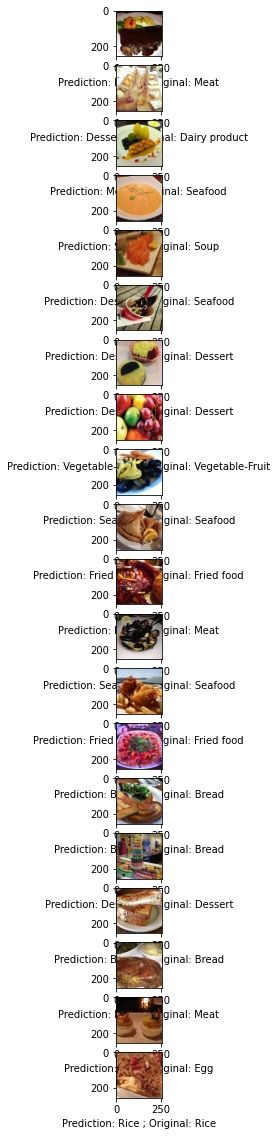

In [20]:
# Visualize the Results

import random
fig = plt.figure(figsize= (100,20))
for i in range(21):
    j = random.randint(0, len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] + ' ; Original: ' + original[j])
    plt.imshow(image[j])

# Create a tight layout
fig.tight_layout()
plt.show()

In [21]:
# Print the Classification Report

print(classification_report(np.asarray(original), np.asarray(prediction)))

                 precision    recall  f1-score   support

          Bread       0.88      0.89      0.88       368
  Dairy product       0.83      0.70      0.76       148
        Dessert       0.85      0.86      0.86       500
            Egg       0.88      0.87      0.88       335
     Fried food       0.91      0.89      0.90       287
           Meat       0.91      0.92      0.91       432
  Noodles-Pasta       1.00      0.99      0.99       147
           Rice       0.95      0.96      0.95        96
        Seafood       0.93      0.91      0.92       303
           Soup       0.97      0.97      0.97       500
Vegetable-Fruit       0.86      0.96      0.91       231

       accuracy                           0.90      3347
      macro avg       0.91      0.90      0.90      3347
   weighted avg       0.90      0.90      0.90      3347



Text(0.5, 1.0, 'Confusion_Matrix')

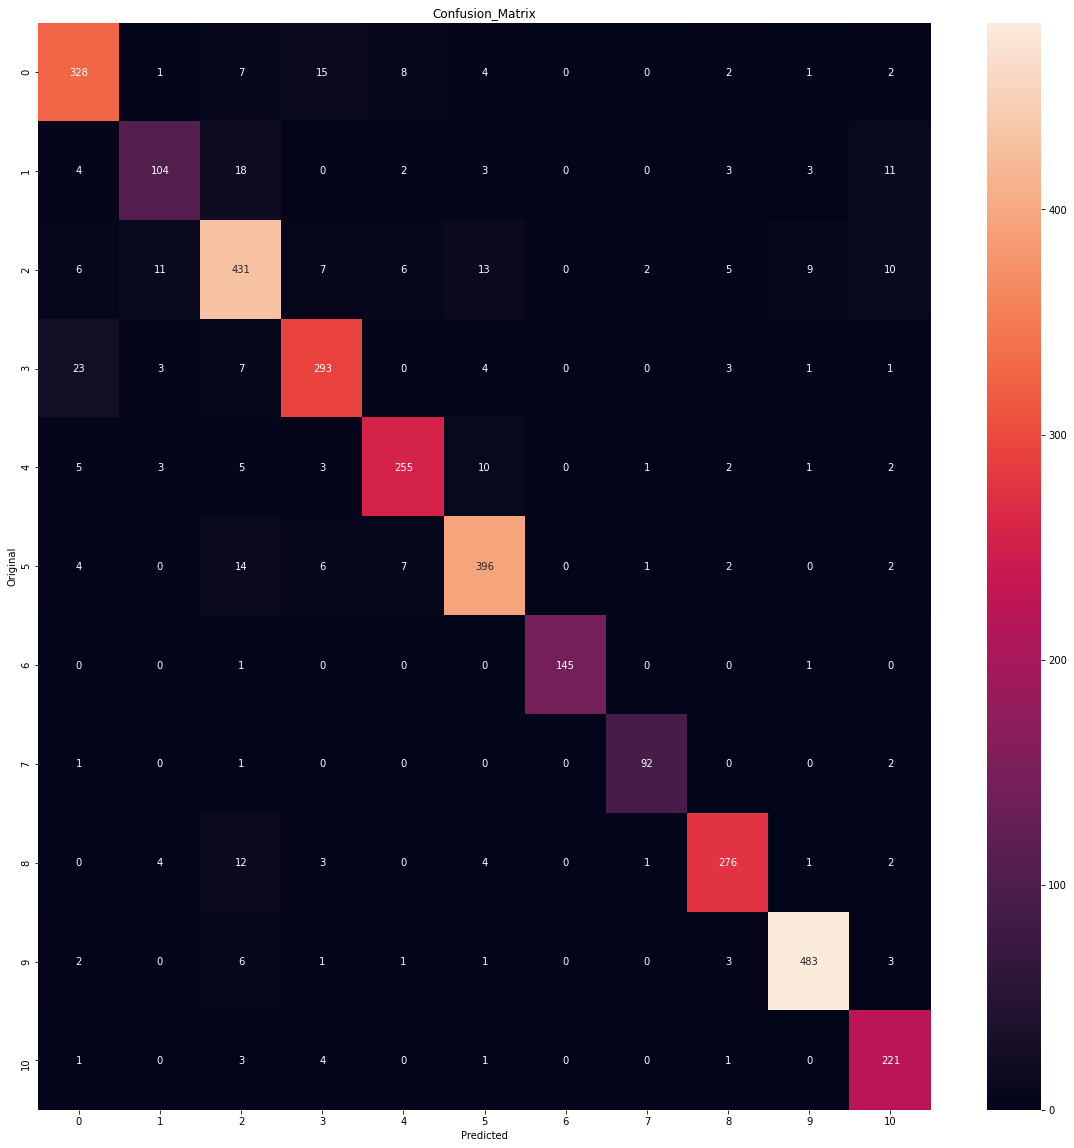

In [22]:
# Plotting the Confusion Matrix

plt.figure(figsize= (20, 20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot= True, fmt= '0.0f', ax= ax)

# Label the plot
ax.set_xlabel("Predicted")
ax.set_ylabel('Original')
ax.set_title("Confusion_Matrix")